In [1]:
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import nltk
from datetime import datetime
import numpy as np

from transformers import AutoModelForSequenceClassification
from transformers import TextClassificationPipeline
from transformers import AutoTokenizer  # Or BertTokenizer

d:\Programas\anaconda3\envs\datasets_iat\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
year = '2018'

In [ ]:
# Main functions 

def separate_case_files(main_df, second_df):

    ''' This code performs a left join between main_df and second_df based on the 'expediente_n°_' column, 
    and then returns a new DataFrame output_df that contains only the rows from main_df that do not have 
    a matching row in second_df based on the 'expediente_n°_' column.'''

    # Perform the merge and filter the results
    output_df = pd.merge(main_df, 
                         second_df[['case_file']], 
                         on='case_file', 
                         how='left', 
                         indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
    
    return output_df

# Function that creates a new dataset with only the cases that are associated with at least one 'acto_' containing 'vista'

def filter_vista_cases(df):

    ''' This code creates a new dataset with only the cases files that contains a higher court decision.'''
        
    # Create a boolean Series where True indicates that 'acto_' contains 'vista'
    contains_keyword = df['resolution_type'].str.contains('VISTA', na=False)

    # Group by 'expediente_n°_' and check if any 'acto_' in each group contains 'vista'
    grouped = df.groupby('case_file').apply(lambda x: any(x['resolution_type'].str.contains('VISTA', na=False)))

    # Create a new DataFrame containing only the 'expediente_n°_' that are associated with at least one 'acto_' containing 'vista'
    output_df = df[df['case_file'].isin(grouped[grouped].index)]
    
    return output_df


# Function that creates a new dataset with only the cases that are associated with at least one 'acto_' containing a specific keyword 

def filter_keywords_cases(df, keywords):

    ''' This code creates a new dataset with only the cases files that contains a specific keyword.'''
    
    # Use str.contains with the regex pattern
    pattern = '|'.join(keywords)

    contains_keyword = df['resolution_type'].str.contains(pattern, case = False ,na=False)
    
    # Group by 'expediente_n°_' and check if any 'acto_' in each group contains any of the keywords
    grouped = df.groupby('case_file').apply(lambda x: any(x['resolution_type'].str.contains(pattern, case = False , na=False)))
    
    # Create a new DataFrame containing only the 'expediente_n°_' that are associated with at least one 'acto_' containing keywords
    output_df = df[df['case_file'].isin(grouped[grouped].index)]
    
    return output_df


def contains_keywords(text, keywords):
    if text is None:
        return False
    text_lower = text.lower()
    return any(keyword.lower() in text_lower for keyword in keywords)


In [ ]:
# This function calls a trained model that classifies if a text is a name or not. 
# This is useful to filter out the no names texts in the column 'judge_from_opinion'.
# We will use this model after identifying which texts are final decisions, just to save CPU time.

tokenizer = AutoTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')
bert_model = AutoModelForSequenceClassification.from_pretrained("JFernandoGRE/classificator_names")
pipe_model = TextClassificationPipeline(model=bert_model, tokenizer=tokenizer)

def get_score(text):
    if pd.isna(text):
        return np.nan  
    return pipe_model(text, return_all_scores=True)[0][1]['score']

In [ ]:
# Reading the dataset

documents_amag = pd.read_csv(rf'D:\Proyectos\amag\case_files_{year}.csv')

documents_amag['issued_date'] = pd.to_datetime(documents_amag['issued_date'])
documents_amag['start_date'] = pd.to_datetime(documents_amag['start_date'])
# Getting how many casefiles we have


documents_amag['judge_from_opinion'] = documents_amag['judge_from_opinion'].apply(lambda x: np.nan if isinstance(x, str) and len(x) > 40 else x)

expediente_counts = documents_amag['case_file'].value_counts()
total_unique_files = expediente_counts.shape[0]
print("Total case files:", total_unique_files)

### 1) Separating Case Files
The first step in the analysis process is to separate the case files into two distinct categories:

1. Case Files Finished by Judgment
2. Case Files Not Finished by Judgment

**Case Files Finished by Judgment** 
- These are the case files that have reached a final decision or judgment. They represent cases that have been resolved and concluded, if they were not appealed. These files typically contain the final ruling or sentence, along with the supporting evidence and legal arguments that led to the decision.

- Identifying and separating these case files is crucial because they represent the completed cases, where the legal process has run its course, and a **definitive outcome** has been reached.

**Case Files Not Finished by Judgment**
- In contrast, this category encompasses case files that have not yet reached a final judgment or decision, but could be concluded by other means. Also, these files could also represent ongoing or unresolved cases that are still in progress within the judicial system.

- There could be various reasons why a case file falls into this category:

    - The case is still being investigated or processed.
    - The case was closed by an order.
    - The parties requested concluding the procedure

Separating these case files from those finished by judgment is essential because they require different handling and analysis.

By clearly distinguishing between these two categories, the analysis can proceed more efficiently, focusing on the appropriate set of case files based on the specific objectives and requirements of the project.

In [ ]:
judgements_df = documents_amag[documents_amag['resolution_type'].str.contains('sentencia', case=False, na=False)]

orders_df = separate_case_files(documents_amag, judgements_df)

In [ ]:
expediente_counts = judgements_df['case_file'].value_counts()
a = expediente_counts.shape[0]
print("Total case files finished by judgements:", a)

expediente_counts = orders_df['case_file'].value_counts()
b = expediente_counts.shape[0]
print("Total case files not finished by judgements:", b)

print("Total case files", a + b)

### 2. Approach with judgements

**Goals**

- Measure how much time it took to solve the case.
- Identify if the first instance decision was confirmed or reversed.

**Approach**

For the case files that have reached a final judgment, we can further separate them into two groups:

1. Case Files with Higher Court Decision
2. Case Files with No Higher Court Decision

**Case Files with Higher Court Decision**
- These case files represent cases that have gone through two or multiple levels of the judicial system, typically involving an appeal process. By analyzing these files, we can:

    - Compare the decisions made at different levels of the judicial hierarchy (e.g., first instance vs. higher court).
    - Identify cases where the initial decision was confirmed or reversed by the higher court.

- Studying these case files can provide valuable insights into the efficiency and consistency of the judicial system, as well as the factors that influence the outcome of appealed cases.

**Case Files with No Higher Court Decision**
- These case files represent cases that were resolved at the initial level, without any further appeals or higher court involvement. By analyzing these files, we can:

    - Measure the duration of the legal process from filing to the final decision at the first instance.

By separating the case files based on the presence of a higher court decision, we can gain valuable insights into different aspects of the judicial system, such as the duration of legal proceedings, the consistency of decisions across different levels, and the factors that influence the outcome of appealed cases.

In [4]:
# List of keywords to filter out
keywords = ['AUTO Q DECLARA CONSENTIDA LA SENTENCIA', 'AUTO QUE DECLARA CONSENTIDA SENTENCIA', 'PUESTA A DESPACHO PARA SENTENCIA',
            'AUTO QUE DECLARA CONSENTIDA LA SENTENCIA/AUTO DE VISTA', 'RESOLUCION DE TRAIGASE PARA SENTENCIAR',
            'APELACION DE SENTENCIA', 'AUTO QUE DECLARA CONSENTIDA LA SENTENCIA', 'AUTO DE INTEGRACION DE SENTENCIA',
            'EJECUCION DE SENTENCIA', 'AMPLIACION DE SENTENCIA']

# Check if the 'resolution_type' column contains any of the keywords
mask = judgements_df['resolution_type'].str.contains('|'.join(keywords), case=False)

no_judgments = judgements_df[mask]
# Drop the rows containing the keywords in the 'resolution_type' column
judgements_df = judgements_df[~mask]

In [5]:
label_counts = judgements_df['resolution_type'].value_counts()
label_counts

SENTENCIA                                        38218
SENTENCIA DE VISTA                                9797
SENTENCIA FUNDADA                                  939
SENTENCIA FUNDADA EN PARTE                         657
SENTENCIA INFUNDADA                                609
SENTENCIA DE VISTA QUE CONFIRMA (A EJECUCION)      349
SENTENCIA FUNDADA LA DEMANDA                       205
SENTENCIA IMPROCEDENTE                              89
SENTENCIA DE VISTA QUE CONFIRMA (A ARCHIVO)         61
SENTENCIA DE VISTA QUE ANULA (A TRAMITE)            54
SENTENCIA DE VISTA QUE REVOCA (A EJECUCION)         35
SENTENCIA INFUNDADA LA DEMANDA                      18
SENTENCIA DE VISTA QUE REVOCA (A ARCHIVO)           16
SENTENCIA DE VISTA QUE ANULA (A EJECUCION)           2
Name: resolution_type, dtype: int64

In [ ]:
expediente_counts = judgements_df['case_file'].value_counts()
a = expediente_counts.shape[0]
print("Total case files finished by judgements:", a)

In [ ]:
expediente_counts = judgements_df['case_file'].value_counts()
expediente_counts

In [ ]:
# Create three subsets based on the specified criteria
single_observation = expediente_counts[expediente_counts == 1]
second_observations = expediente_counts[expediente_counts == 2]
third_observations = expediente_counts[(expediente_counts >= 3) & (expediente_counts <= 10)]

total_count = len(expediente_counts)
single_percentage = len(single_observation) / total_count * 100
second_percentage = len(second_observations) / total_count * 100
third_percentage = len(third_observations) / total_count * 100

# Plotting
plt.figure(figsize=(10, 6))

labels = ['One Decision', 'Two Decisions', 'Many Decisions']
sizes = [single_percentage, second_percentage, third_percentage]
colors = ['blue', 'orange', 'green']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Judgements per Casefile')

plt.show()

2.1. **Separating casefiles finished by judgments**

- judgements_2 contains casefiles with a second instance decision.
- judgements_1 contains casefiles with no second instance decision.

In [ ]:
judgements_2 = filter_vista_cases(judgements_df)
judgements_1 = separate_case_files(judgements_df, judgements_2)

In [ ]:
judgements_2['second_instance'] = True
judgements_1['second_instance'] = False

2.2. Working with casefiles with no second instance decision

Our goal is obtain casefiles with only one decision. 

In [ ]:
# Since a casefile with no appeal could not have more than one final decision, our dataset must not have more than one row per case file. 

expediente_counts = judgements_1['case_file'].value_counts()

# Create three subsets based on the specified criteria
single_observation = expediente_counts[expediente_counts == 1]
second_observations = expediente_counts[expediente_counts == 2]
third_observations = expediente_counts[(expediente_counts >= 3) & (expediente_counts <= 10)]

total_count = len(expediente_counts)
single_percentage = len(single_observation) / total_count * 100
second_percentage = len(second_observations) / total_count * 100
third_percentage = len(third_observations) / total_count * 100

# Plotting
plt.figure(figsize=(10, 6))

labels = ['One Decision', 'Two Decisions', 'Many Decisions']
sizes = [single_percentage, second_percentage, third_percentage]
colors = ['blue', 'orange', 'green']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Decisions per Casefile')

plt.show()

In [ ]:
# Calculate the difference in days between 'issued_date' and 'start_date' columns

judgements_1['days_difference'] = (judgements_1['issued_date'] - judgements_1['start_date']).dt.days

2.3. Working with case_files with second instance decisions

In [ ]:
# I expect that, at least, I must have two decisions. First instance decision with its second instance decision. 

expediente_counts = judgements_2['case_file'].value_counts()

# Create three subsets based on the specified criteria
single_observation = expediente_counts[expediente_counts == 1]
second_observations = expediente_counts[expediente_counts == 2]
third_observations = expediente_counts[(expediente_counts >= 3) & (expediente_counts <= 10)]

total_count = len(expediente_counts)
single_percentage = len(single_observation) / total_count * 100
second_percentage = len(second_observations) / total_count * 100
third_percentage = len(third_observations) / total_count * 100

# Plotting
plt.figure(figsize=(10, 6))

labels = ['One Decision', 'Two Decisions', 'Many Decisions']
sizes = [single_percentage, second_percentage, third_percentage]
colors = ['blue', 'orange', 'green']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Decisions per Casefile')

plt.show()

In [ ]:
# Case files with only a single decision is weird, since it must has its first instance decision associated to it. 
# That's why we will remove it from our dataset

single_observation = expediente_counts[expediente_counts == 1].index

# Remove rows where 'case_file' is in single_observation
judgements_2 = judgements_2[~judgements_2['case_file'].isin(single_observation)]

In [ ]:
# Calculate the difference in days between 'issued_date' and 'start_date' columns
judgements_2['days_difference'] = (judgements_2['issued_date'] - judgements_2['start_date']).dt.days

We have 7931 cases files that contains first and second instance decisions. 
We have a good sign, since most of our case files only contains two decisions, which means we have a first instance decision, and its correspondent second instance. 
We must remember, by convention, we assign the term 'vista' to the judicial decisions that are solving an appelation. 

In [ ]:
judgements_case_file = pd.concat([judgements_1, judgements_2], ignore_index=True)

In [ ]:
# Fixing the names with BERT

# Apply the function to the 'JUDGE_FROM_OPINION' column and create the 'SCORE' column
judgements_case_file['score'] = judgements_case_file['judge_from_opinion'].apply(get_score)

judgements_case_file.loc[judgements_case_file['score'] < 0.998, 'judge_from_opinion'] = np.nan  # Set NaN where score > 0.998

# Copy content from 'judge' to 'judge_from_opinion' where 'judge_from_opinion' is empty
judgements_case_file['judge_from_opinion'].replace('', np.nan, inplace=True)  # Ensure empty strings are treated as NaN
judgements_case_file['judge_from_opinion'].fillna(judgements_case_file['judge'], inplace=True)

In [ ]:
judgements_case_file.to_csv(rf'D:\Proyectos\amag\classification\intermediate\judgements_case_file_{year}.csv', index=False)

**2.3. Getting the outcome of the second instance decision.**

Our goal is keeping one decision, which is the second instance, and extract its outcome.

For this approach, we have binary classification. Confirmed or Reversed.

We must take into account that we could have partial confirmation when the higher judge confirms partially a decision.

When the last thing happens, we assume it was confirmed. 

In [ ]:
condition_acto = judgements_2['resolution_type'].str.contains('vista', case=False, na=False)
judgements_2_v = judgements_2[condition_acto]

In [ ]:
expediente_counts = judgements_2_v['case_file'].value_counts()

# Create three subsets based on the specified criteria
single_observation = expediente_counts[expediente_counts == 1]
second_observations = expediente_counts[expediente_counts == 2]
third_observations = expediente_counts[(expediente_counts >= 3) & (expediente_counts <= 10)]

total_count = len(expediente_counts)
single_percentage = len(single_observation) / total_count * 100
second_percentage = len(second_observations) / total_count * 100
third_percentage = len(third_observations) / total_count * 100

# Plotting
plt.figure(figsize=(10, 6))

labels = ['One Decision', 'Two Decisions', 'Many Decisions']
sizes = [single_percentage, second_percentage, third_percentage]
colors = ['blue', 'orange', 'green']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Decisions per Casefile')

plt.show()

In [23]:
def extract_last_n_words(text, n=300):
    # Verifica si el texto es una cadena
    if isinstance(text, str):
        # Divide el texto en palabras
        words = text.split()
        # Extrae las últimas n palabras
        last_n_words = words[-n:]
        # Une las palabras en un solo string
        return ' '.join(last_n_words)
    else:
        return ''  # Retorna una cadena vacía si el texto no es una cadena

# Aplicar la función a la columna del DataFrame
judgements_2_v['verdict_text'] = judgements_2_v['opinion_text'].apply(lambda x: extract_last_n_words(x, 300))

In [24]:
confirm_pattern =re.compile(r'c\s*o\s*n\s*f\s*i\s*r\s*m\s*', re.IGNORECASE)
consent_pattern =re.compile(r'c\s*o\s*n\s*s\s*e\s*n\s*t\s*', re.IGNORECASE)

# Reversal patterns

infundada_pattern = re.compile(r'i\s*n\s*f\s*u\s*n\s*d\s*a\s*', re.IGNORECASE)
revoc_pattern = re.compile(r'r\s*e\s*v\s*o\s*c\s*', re.IGNORECASE)
improcedente_pattern = re.compile(r'i\s*m\s*p\s*r\s*o\s*c\s*e\s*d\s*e\s*n\s*t\s*e\s*', re.IGNORECASE)


# Function to classify text based on keywords
def classify_text_2(text):
    if not isinstance(text, str):
        text = str(text) if text is not None else ''
    
    if confirm_pattern.search(text) or consent_pattern.search(text):
        return 'Confirmation'
    
    elif infundada_pattern.search(text) or revoc_pattern.search(text) or improcedente_pattern.search(text):
        return 'Reversal'

    else:
        return 'Ambiguous'
    
judgements_2_v['outcome'] = (judgements_2_v['summary'].fillna('') + ' ' + judgements_2_v['resolution_type'].fillna('')+ ' ' + judgements_2_v['verdict_text'].fillna('')).apply(classify_text_2)

In [25]:
judgements_2_v.to_csv(rf'D:\Proyectos\amag\classification\intermediate\appealed_judgments_outcomes_{year}.csv', index=False)

## Second Step of the Filter

We will assume that the case files above were solved (we have, at least, 42, 385). We will do the following:

1. Remove the closed case files from the sentencias_df.
2. Keep only the rows that contains the word 'auto' in the column 'resolution_type'. As it was explained before, if there is no judgement, a procedure could be ended by an 'auto'.
3. We will create two datasets, the first one with lower and higher court decisions, and the other one with only the lower court decision. 

In [ ]:
orders_df = orders_df[orders_df['resolution_type'].str.contains('auto', case=False, na=False)]

There are two ways an order could end a procedure. The first one if the parties, or one of them, request it. The second one is if a judge decides it. 

Then, we will have three groups:

orders_1 = contains casefiles with no appeals

orders_2 = contains casefiles with orders that were appealed by the parties

In [ ]:
orders_df['days_difference'] = (orders_df['issued_date'] - orders_df['start_date']).dt.days

In [ ]:
orders_2 = filter_vista_cases(orders_df)
orders_1 = separate_case_files(orders_df, orders_2)

In [ ]:
orders_2['second_instance'] = True

# Add the 'second_instance' column to orders_1 and set all values to 'No'
orders_1['second_instance'] = False 

**3.1. Our goal is obtain casefiles with only one final decision**

In [ ]:
keywords = ['desistimiento', 'conciliación', 'conciliacion',
            'allanamiento', 'transacción', 'reconocimiento', 'abandono',
            'transaccion', 'final', 'improcedente', 'archivo definitivo', 
            'incompetencia', 'improcedencia',
            'sustraccion de la materia', 'conclusion']

orders_1 = orders_1[orders_1['resolution_type'].str.contains('|'.join(keywords), case=False, na=False)]

In [ ]:
expediente_counts = orders_1['case_file'].value_counts()

# Create three subsets based on the specified criteria
single_observation = expediente_counts[expediente_counts == 1]
second_observations = expediente_counts[expediente_counts == 2]
third_observations = expediente_counts[(expediente_counts >= 3) & (expediente_counts <= 10)]

total_count = len(expediente_counts)
single_percentage = len(single_observation) / total_count * 100
second_percentage = len(second_observations) / total_count * 100
third_percentage = len(third_observations) / total_count * 100

# Plotting
plt.figure(figsize=(10, 6))

labels = ['One Decision', 'Two Decisions', 'Many Decisions']
sizes = [single_percentage, second_percentage, third_percentage]
colors = ['blue', 'orange', 'green']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Decision per Casefile')

plt.show()

In [ ]:
expediente_counts = orders_1['case_file'].value_counts()
expediente_counts

**3.2. Working with appealed orders** 

In [ ]:
# We must identify the first instance decision autos in the case files

keywords = ['desistimiento', 'conciliación', 'conciliacion',
            'allanamiento', 'transacción', 'reconocimiento', 'abandono',
            'transaccion', 'final', 'improcedente', 'archivo definitivo', 
            'incompetencia', 'improcedencia',
            'sustraccion de la materia', 'conclusion']

orders_2_v = filter_keywords_cases(orders_2, keywords)

In [ ]:
keywords = ['desistimiento', 'conciliación', 'conciliacion',
            'allanamiento', 'transacción', 'reconocimiento', 'abandono',
            'transaccion', 'final', 'improcedente', 'archivo definitivo', 
            'incompetencia', 'improcedencia',
            'sustraccion de la materia', 'conclusion', 'vista']

orders_2_v = orders_2_v[orders_2_v['resolution_type'].str.contains('|'.join(keywords), case=False, na=False)]

In [ ]:
expediente_counts = orders_2_v['case_file'].value_counts()

# Create three subsets based on the specified criteria
single_observation = expediente_counts[expediente_counts == 1]
second_observations = expediente_counts[expediente_counts == 2]
third_observations = expediente_counts[(expediente_counts >= 3) & (expediente_counts <= 10)]

total_count = len(expediente_counts)
single_percentage = len(single_observation) / total_count * 100
second_percentage = len(second_observations) / total_count * 100
third_percentage = len(third_observations) / total_count * 100

# Plotting
plt.figure(figsize=(10, 6))

labels = ['One Decision', 'Two Decisions', 'Many Decisions']
sizes = [single_percentage, second_percentage, third_percentage]
colors = ['blue', 'orange', 'green']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Decision per Casefile')

plt.show()

In [ ]:
orders_case_file = pd.concat([orders_1, orders_2], ignore_index=True)

In [ ]:
# Fixing the names with BERT

# Apply the function to the 'JUDGE_FROM_OPINION' column and create the 'SCORE' column
orders_case_file['score'] = orders_case_file['judge_from_opinion'].apply(get_score)

orders_case_file.loc[orders_case_file['score'] < 0.998, 'judge_from_opinion'] = np.nan  # Set NaN where score > 0.998

# Copy content from 'judge' to 'judge_from_opinion' where 'judge_from_opinion' is empty
orders_case_file['judge_from_opinion'].replace('', np.nan, inplace=True)  # Ensure empty strings are treated as NaN
orders_case_file['judge_from_opinion'].fillna(orders_case_file['judge'], inplace=True)

In [ ]:
orders_case_file.to_csv(rf'D:\Proyectos\amag\classification\intermediate\orders_case_file_{year}.csv', index=False)

In [87]:
import pandas as pd
import regex as re

year = '2022'

orders = pd.read_csv(rf'D:\Proyectos\amag\classification\intermediate\orders_case_file_{year}.csv')
def extract_last_n_words(text, n=300):
    # Verifica si el texto es una cadena
    if isinstance(text, str):
        # Divide el texto en palabras
        words = text.split()
        # Extrae las últimas n palabras
        last_n_words = words[-n:]
        # Une las palabras en un solo string
        return ' '.join(last_n_words)
    else:
        return ''  # Retorna una cadena vacía si el texto no es una cadena


# Aplicar la función a la columna del DataFrame
orders['verdict_text'] = orders['opinion_text'].apply(lambda x: extract_last_n_words(x, 300))

orders_2_inst = orders[orders['resolution_type'].str.contains('vista', case=False, na=False)]

In [26]:
conciliacion_pattern = re.compile(r'c\s*o\s*n\s*c\s*i\s*l\s*i\s*a\s*', re.IGNORECASE)
transaccion_pattern = re.compile(r't\s*r\s*a\s*n\s*s\s*a\s*c\s*c\s*i\s*o\s*n\s*', re.IGNORECASE)

# Dropped by plaintiff patterns

abandono_pattern = re.compile(r'a\s*b\s*a\s*n\s*d\s*o\s*n\s*o\s*', re.IGNORECASE)
desistimiento_pattern = re.compile(r'd\s*e\s*s\s*i\s*s\s*t\s*i\s*m\s*i\s*e\s*n\s*t\s*o\s*', re.IGNORECASE)
inasist_pattern = re.compile(r'i\s*n\s*a\s*s\s*i\s*s\s*t\s*', re.IGNORECASE)


# Negative patterns

infundada_pattern = re.compile(r'i\s*n\s*f\s*u\s*n\s*d\s*a\s*', re.IGNORECASE)
improcedente_pattern = re.compile(r'i\s*m\s*p\s*r\s*o\s*c\s*e\s*d\s*e\s*n\s*t\s*e\s*', re.IGNORECASE)
rechazar_pattern = re.compile(r'r\s*e\s*c\s*h\s*a\s*z\s*a\s*r\s*', re.IGNORECASE)
nulidad_pattern = re.compile(r'n\s*u\s*l\s*i\s*d\s*a\s*d\s*', re.IGNORECASE)    
incompentencia_pattern = re.compile(r'i\s*n\s*c\s*o\s*m\s*p\s*e\s*t\s*e\s*n\s*c\s*i\s*a\s*', re.IGNORECASE)
sin_declaración_pattern = re.compile(r's\s*i\s*n\s*d\s*e\s*c\s*l\s*a\s*r\s*a\s*c\s*i\s*ó\s*n\s*', re.IGNORECASE)

# Partial patterns

fundada_en_parte_pattern = re.compile(r'f\s*u\s*n\s*d\s*a\s*d\s*a\s*e\s*n\s*p\s*a\s*r\s*t\s*e\s*', re.IGNORECASE)

# Positive patterns

fundada_pattern = re.compile(r'f\s*u\s*n\s*d\s*a\s*d\s*a\s*', re.IGNORECASE)
llevar_adelante_pattern = re.compile(r'l\s*l\s*e\s*v\s*a\s*r\s*\s*a\s*d\s*e\s*l\s*a\s*n\s*t\s*e\s*', re.IGNORECASE)
allana_pattern = re.compile(r'a\s*l\s*l\s*a\s*n\s*a\s*', re.IGNORECASE)
adelante_pattern = re.compile(r'a\s*d\s*e\s*l\s*a\s*n\s*t\s*e\s*', re.IGNORECASE)

# Function to classify text based on keywords
def classify_text(text):
    if not isinstance(text, str):
        text = str(text) if text is not None else ''
    
    if conciliacion_pattern.search(text) or transaccion_pattern.search(text):
        return 'Settlement'
    
    elif abandono_pattern.search(text) or desistimiento_pattern.search(text) or inasist_pattern.search(text):
        return 'Dropped by Plaintiff'
    
    elif fundada_en_parte_pattern.search(text):
        return 'Partial'
    
    elif infundada_pattern.search(text) or improcedente_pattern.search(text) or rechazar_pattern.search(text) or nulidad_pattern.search(text) or incompentencia_pattern.search(text) or sin_declaración_pattern.search(text):
        return 'Defendant'
    
    elif fundada_pattern.search(text) or llevar_adelante_pattern.search(text) or allana_pattern.search(text) or adelante_pattern.search(text):
        return 'Plaintiff'

    else:
        return 'Ambiguous'
    
orders_1_inst['outcome'] = (orders_1_inst['summary'].fillna('') + ' ' + orders_1_inst['resolution_type'].fillna('')+ ' ' + orders_1_inst['verdict_text'].fillna('')).apply(classify_text)

C:\Users\PC\AppData\Local\Temp\ipykernel_17876\3057595888.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_1_inst['outcome'] = (orders_1_inst['summary'].fillna('') + ' ' + orders_1_inst['resolution_type'].fillna('')+ ' ' + orders_1_inst['verdict_text'].fillna('')).apply(classify_text)


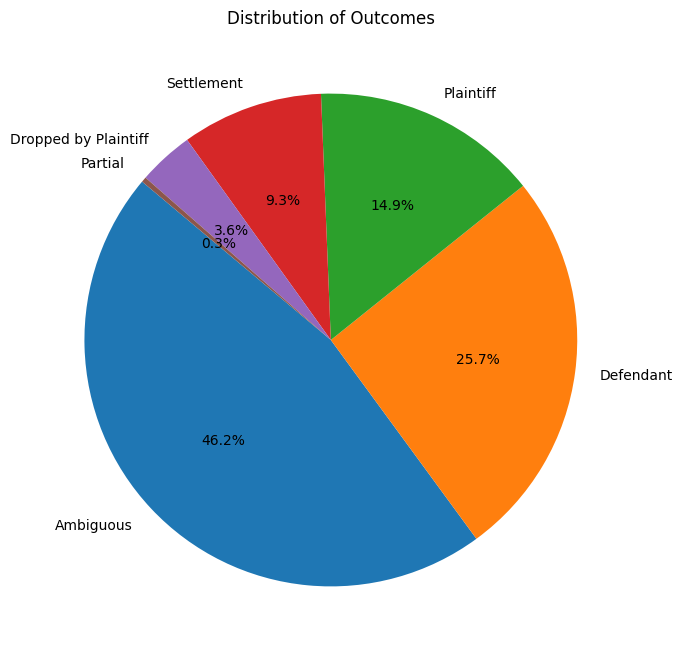

In [27]:
import matplotlib.pyplot as plt

outcome_counts = orders_1_inst['outcome'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(outcome_counts, labels=outcome_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Outcomes')
plt.show()

In [88]:
confirm_pattern =re.compile(r'c\s*o\s*n\s*f\s*i\s*r\s*m\s*', re.IGNORECASE)
consent_pattern =re.compile(r'c\s*o\s*n\s*s\s*e\s*n\s*t\s*', re.IGNORECASE)

# Reversal patterns

revoc_pattern = re.compile(r'r\s*e\s*v\s*o\s*c\s*', re.IGNORECASE)
improcedente_pattern = re.compile(r'i\s*m\s*p\s*r\s*o\s*c\s*e\s*d\s*e\s*n\s*t\s*e\s*', re.IGNORECASE)
nul_pattern = re.compile(r'n\s*u\s*l\s*', re.IGNORECASE)


# Function to classify text based on keywords
def classify_text_2(text):
    if not isinstance(text, str):
        text = str(text) if text is not None else ''
    
    if confirm_pattern.search(text) or consent_pattern.search(text):
        return 'Confirmation'
    
    elif  revoc_pattern.search(text) or improcedente_pattern.search(text) or nul_pattern.search(text):
        return 'Reversal'

    else:
        return 'Ambiguous'
    
orders_2_inst['outcome'] = (orders_2_inst['summary'].fillna('') + ' ' + orders_2_inst['resolution_type'].fillna('')+ ' ' + orders_2_inst['verdict_text'].fillna('')).apply(classify_text_2)

C:\Users\PC\AppData\Local\Temp\ipykernel_17876\106749589.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_2_inst['outcome'] = (orders_2_inst['summary'].fillna('') + ' ' + orders_2_inst['resolution_type'].fillna('')+ ' ' + orders_2_inst['verdict_text'].fillna('')).apply(classify_text_2)


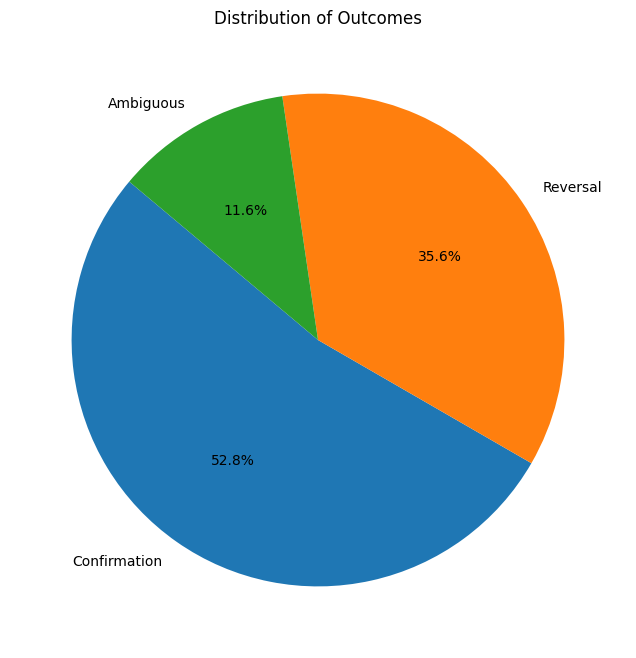

In [89]:
outcome_counts = orders_2_inst['outcome'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(outcome_counts, labels=outcome_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Outcomes')
plt.show()

In [90]:
orders_2_inst.to_csv(rf'D:\Proyectos\amag\classification\intermediate\appealed_orders_outcomes_{year}.csv', index=False)